In [8]:
import neattext as nt
import nltk
from nltk.corpus import words, names
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
#neattext

In [2]:
filename='..\DatasetEnglish.csv'
data=pd.read_csv(filename)

In [3]:
data=data.drop(['index'], axis=1)
data.head()

,mongodb_id,has_preview,shortened_url,comments_enabled,comments_logged_in_only,talk_id,talk_slug,talk_title,talk_social_title,speakers_name,...,related_talk_5_id,speakers_typename,speakers_firstname,speakers_lastname,speakers_description,speakers_is_live,speakers_who_they_are,speakers_why_listen,external_service,external_service_code
0,652af294d95841780141bab7,False,https://go.ted.com/6Ryx,False,False,2147,aakash_odedra_a_dance_in_a_hurricane_of_paper_...,"A dance in a hurricane of paper, wind and light","A dance in a hurricane of paper, wind and light",Aakash Odedra,...,2273.0,AcmeSpeaker,Aakash,Odedra,Choreographer,True,Aakash Odedra sets raw ancient dance forms fro...,Based in the UK with a growing international r...,YouTube,T49IjKho5y8
1,652af54dd95841780141bab8,False,https://go.ted.com/6sZX,False,False,2683,aala_el_khani_what_it_s_like_to_be_a_parent_in...,What it's like to be a parent in a war zone,What it's like to be a parent in a war zone,Aala El-Khani,...,36063.0,AcmeSpeaker,Aala,El-Khani,Humanitarian psychologist,True,Aala El-Khani explores the needs of families a...,<p>Dr. Aala El-Khani researches and develops i...,YouTube,dY9f9bFctUE
2,652af54dd95841780141bab9,False,https://go.ted.com/6yKv,False,False,91525,aarathi_krishnan_5_ethical_principles_for_digi...,5 ethical principles for digitizing humanitari...,NaN,Aarathi Krishnan,...,24354.0,AcmeSpeaker,Aarathi,Krishnan,Tech and human rights ethicist,True,Aarathi Krishnan designs institutions and syst...,<p>Aarathi Krishnan works at the intersections...,YouTube,Ix8Cz-veat4
3,652af54dd95841780141baba,False,https://go.ted.com/6RgH,True,True,101504,aaron_bastani_a_socialist_perspective_on_the_p...,A socialist perspective on the pursuit of happ...,NaN,Aaron Bastani,...,972.0,AcmeSpeaker,Aaron,Bastani,Journalist,True,Aaron Bastani covers the issues that will defi...,<div>Aaron Bastani is the cofounder of Novara ...,YouTube,M6aq2SH-xVo
4,652af54dd95841780141babb,False,https://go.ted.com/6JLM,False,False,14610,aaron_duffy_lake_buckley_and_jack_foster_illus...,"""Illusions for a better society""","""Illusions for a better society""","Aaron Duffy, Lake Buckley and Jack Foster",...,NaN,AcmeSpeaker,Aaron,Duffy,NaN,False,Aaron Duffy began employing visual tricks into...,NaN,NaN,NaN


In [99]:
df=data.loc[:,['transcript','talk_id','published_timestamp']]
df.head()

,transcript,talk_id,published_timestamp
0,(Music) (Applause),2147,2014-12-05T16:00:35Z
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z


---
### Prepocessing the transcripts
- audio descriptions
- speaker change/identification
- removing special characters
- tokenizing
- removing stop words
- lemmatizing

In [101]:
# adding the audio descriptions to a separate column
df['transcript'] = df['transcript'].astype(str)
df['Audio_Descriptions'] = df['transcript'].apply(lambda x: re.findall(r'\[[^\]]*\]|\([^\)]*\)', x))
df['transcript'] = df['transcript'].apply(lambda x: re.sub(r'\[[^\]]*\]|\([^\)]*\)', '', x))

In [102]:
df.head()

,transcript,talk_id,published_timestamp,Audio_Descriptions
0,,2147,2014-12-05T16:00:35Z,"[(Music), (Applause)]"
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z,[(Applause)]
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z,"[(Laughter), (Applause), (Applause)]"
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z,"[(Laughter), (Laughter), (Laughter), (Applause..."
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z,"[(Glass breaks), (Music)]"


In [103]:
#Speaker changes at start and inside the text

df['Speaker_Changes_Start'] = df['transcript'].apply(lambda x: re.findall(r'^\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', x))

df['Speaker_Changes_Inside'] = df['transcript'].apply(lambda x: re.findall(r'\.\s*([A-Z][a-z]*(?:\s[A-Z][a-z]*)*)\s*:', x))

In [105]:
df

,transcript,talk_id,published_timestamp,Audio_Descriptions,Speaker_Changes_Start,Speaker_Changes_Inside
0,,2147,2014-12-05T16:00:35Z,"[(Music), (Applause)]",[],[]
1,"Worldwide, over 1.5 billion people experience...",2683,2017-02-10T15:49:37Z,[(Applause)],[],[]
2,Sociologist Zeynep Tufekci once said that his...,91525,2022-06-14T14:45:13Z,"[(Laughter), (Applause), (Applause)]",[],[One]
3,"Allow me to introduce myself. I’m a writer, j...",101504,2023-01-20T15:54:11Z,"[(Laughter), (Laughter), (Laughter), (Applause...",[],"[Chris Anderson, Aaron Bastani]"
4,Narrator: We have you here today specifically...,14610,2018-04-14T19:48:08Z,"[(Glass breaks), (Music)]",[Narrator],"[Wei Ji Ma, N, N, N]"
...,...,...,...,...,...,...
4954,Avocados. Americans love them. For what other...,87879,2022-02-04T15:51:26Z,"[[got milk?], (Laughter), (Laughter and applau...",[],[]
4955,"In 2009, a satellite circled Earth, methodica...",81368,2021-09-14T15:02:59Z,[],[],[]
4956,"We live in a vast universe, on a small wet p...",49223,2019-10-08T21:58:13Z,[],[],[]
4957,"On February 24, my daughter spoke for the fir...",91039,2022-04-14T14:10:09Z,[(Applause)],[],[]


In [80]:
#to check how many of these are false positives

#df[(df['Speaker_Changes_Start'].apply(lambda x: len(x) > 0))].tail(50) | (df['Speaker_Changes_Inside'].apply(lambda x: len(x) > 0))]

#english_words = set(words.words())
#english_names = set(names.words())

#df['English_Words'] = df['Speaker_Changes'].apply(lambda x: [word for word in x if word.lower() in english_words])
#df['Names'] = df['Speaker_Changes'].apply(lambda x: [word for word in x if word in english_names])

In [83]:
#df[df['English_Words'].apply(lambda x: len(x) > 0)]['transcript'].loc[62]
#df[df['Speaker_Changes'].apply(lambda x: len(x) > 0)]['transcript'].loc[4939]



In [108]:
#df['transcript_neat']=df['transcript'].apply(lambda x: nt.TextFrame(x).remove_emails().remove_phone_numbers().remove_urls().text)
#df['transcript_neat']=df['transcript'].apply(lambda x: nt.TextFrame(x).remove_emails().remove_urls().fix_contractions().text)

In [106]:
#df['transcript'].apply(lambda x: nt.TextFrame(x).describe())
def column_summary(series):
    series = series.dropna()
    series = series.str.strip()
    series = series[series != ""]
    summary = {}
    functions = [len, lambda x: len(x.split()), lambda x: len(x.split(".")), lambda x: sum(nt.TextFrame(x).count_vowels().values()), 
                 lambda x: sum(nt.TextFrame(x).count_consonants().values()), lambda x: sum(nt.TextFrame(x).count_stopwords().values()), lambda x: sum(c in ".,;:!?\"'()-" for c in x)]
    labels = ["Length", "Words", "Sentences", "Vowels", "Consonants", "Stopwords", "Punctuations"]
    
    for function, label in zip(functions, labels):
        values = []
        for text in series:
            value = function(text)
            values.append(value)
            
        mean = np.mean(values)
        std = np.std(values)
        mins = np.min(values)
        maxs = np.max(values)
        summary[label] = [mean, std, mins, maxs]
        
    summary = pd.DataFrame(summary, index=["mean", "std", "min", "max"]).T

    return summary



In [107]:
column_summary(df['transcript'])

,mean,std,min,max
Length,9511.063598,5724.546371,3.0,65048.0
Words,1696.951343,1051.966275,1.0,12076.0
Sentences,99.517868,62.760442,1.0,656.0
Vowels,2881.626893,1727.809581,1.0,19854.0
Consonants,4580.326671,2731.600795,2.0,31421.0
Stopwords,916.770644,596.329559,0.0,6938.0
Punctuations,307.229356,218.112267,0.0,2177.0


In [29]:
import numpy as np
# Create conditions
conditions = [
    (df['transcript'] == df['transcript_neat']),  # condition1: strings are the same
    (df['transcript'] != df['transcript_neat'])   # condition2: strings are different
]

# Define the choices to assign for each condition
choices = ['Same', 'Different']

# Create a new column based on the conditions
df['comparison'] = np.select(conditions, choices, default='N/A')

In [90]:
#df[df['comparison']=='Different']['transcript'].apply(lambda x: len(x))
#df[df['comparison']=='Different']['transcript'].loc[3349]

In [91]:
#df[df['comparison']=='Different']['transcript_neat'].loc[3349]

In [86]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Cleaning the text
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Apply the function to the transcript column
df['clean_transcript'] = df['transcript'].apply(clean)

# Split the cleaned transcripts into words
doc_clean = [doc.split() for doc in df['clean_transcript']] 

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Running and Training LDA model on the document term matrix
lda = LdaModel
ldamodel = lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)


In [88]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
vis_data = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)


In [20]:
def preprocessing(text):
    #tokenizing text
    tokens = word_tokenize(text.lower())
    
    # Removing stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatizing the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    processed = ' '.join(lemmatized_tokens)
    return processed

In [44]:
transcript = transcript[transcript['transcript'].notnull()]
transcript['tokenized_transcript'] = transcript.apply(lambda row: nltk.word_tokenize(row['transcript'].lower() if type(row['transcript']) is str else row['transcript']), axis=1)

In [45]:
transcript['tokenized_transcript']

0                           [(, music, ), (, applause, )]
1       [worldwide, ,, over, 1.5, billion, people, exp...
2       [sociologist, zeynep, tufekci, once, said, tha...
3       [allow, me, to, introduce, myself, ., i, ’, m,...
4       [narrator, :, we, have, you, here, today, spec...
                              ...                        
4954    [avocados, ., americans, love, them, ., for, w...
4955    [in, 2009, ,, a, satellite, circled, earth, ,,...
4956    [we, live, in, a, vast, universe, ,, on, a, sm...
4957    [on, february, 24, ,, my, daughter, spoke, for...
4958    [in, the, next, six, minutes, that, you, will,...
Name: tokenized_transcript, Length: 4958, dtype: object

In [ ]:
#contractions

In [ ]:
#after tokenization

text_without_punct = text_with_punct.translate(str.maketrans('', '', string.punctuation))
display(f"Text without punctuation: {text_without_punct}")

In [ ]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

In [ ]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

In [92]:
#transcript['transcript'] = transcript['transcript'].apply(preprocessing)
#transcript.head()

### Sentiment analysis

In [109]:
from textblob import TextBlob
import matplotlib.pyplot as plt
df['clean_transcript'] = df['transcript'].apply(nt.clean_text)

df['sentiment'] = df['clean_transcript'].apply(lambda x: TextBlob(x).sentiment.polarity)


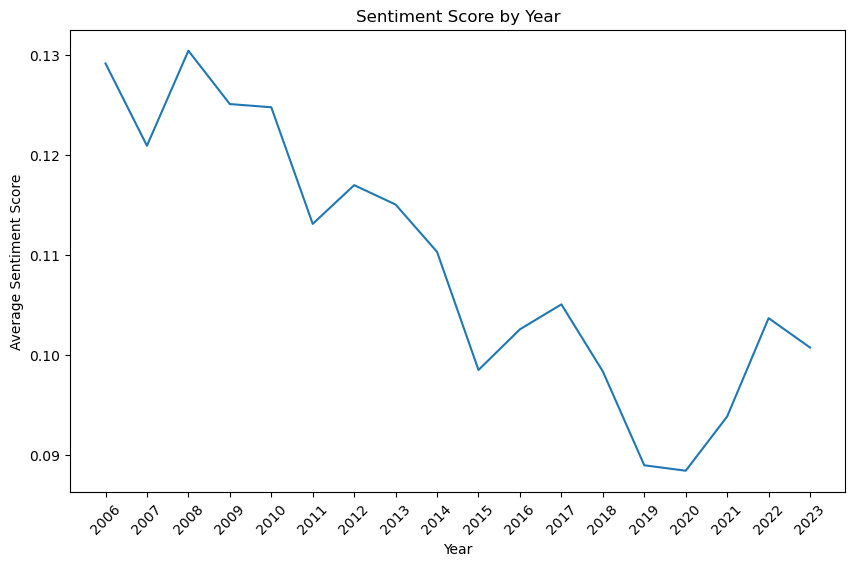

In [116]:
df['year'] = pd.to_datetime(df['published_timestamp']).dt.year.astype(int)
plt.figure(figsize=(10, 6))
df.groupby('year')['sentiment'].mean().plot(kind='line')
plt.title('Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.xticks(df['year'].unique(), rotation=45)
plt.show()

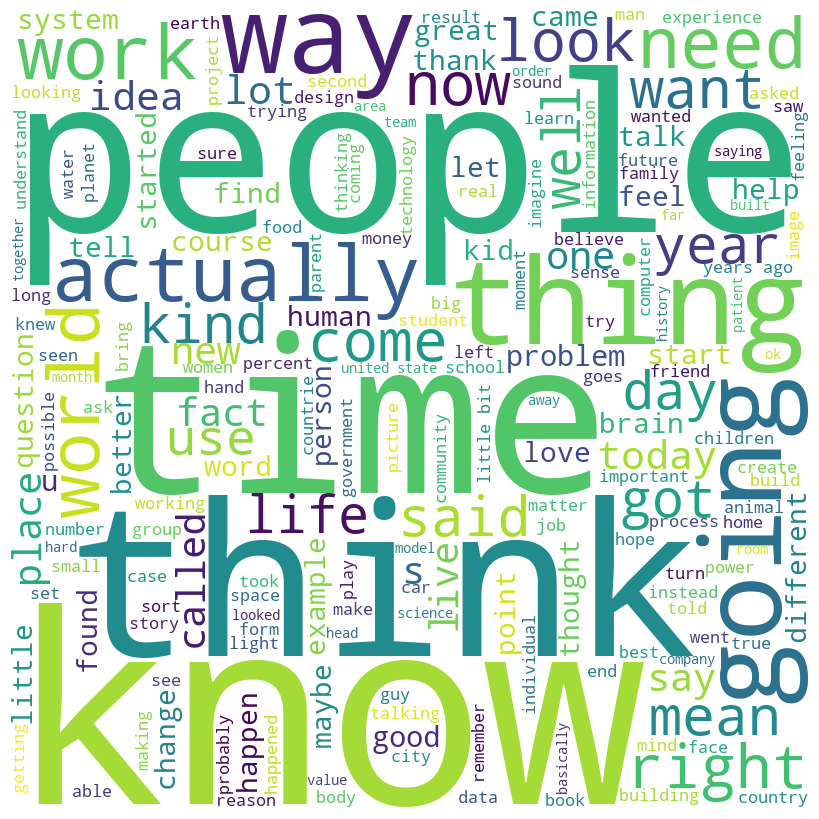

In [117]:
from wordcloud import WordCloud
positive_words = ' '.join(df[df['sentiment'] > 0]['clean_transcript'])
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(positive_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

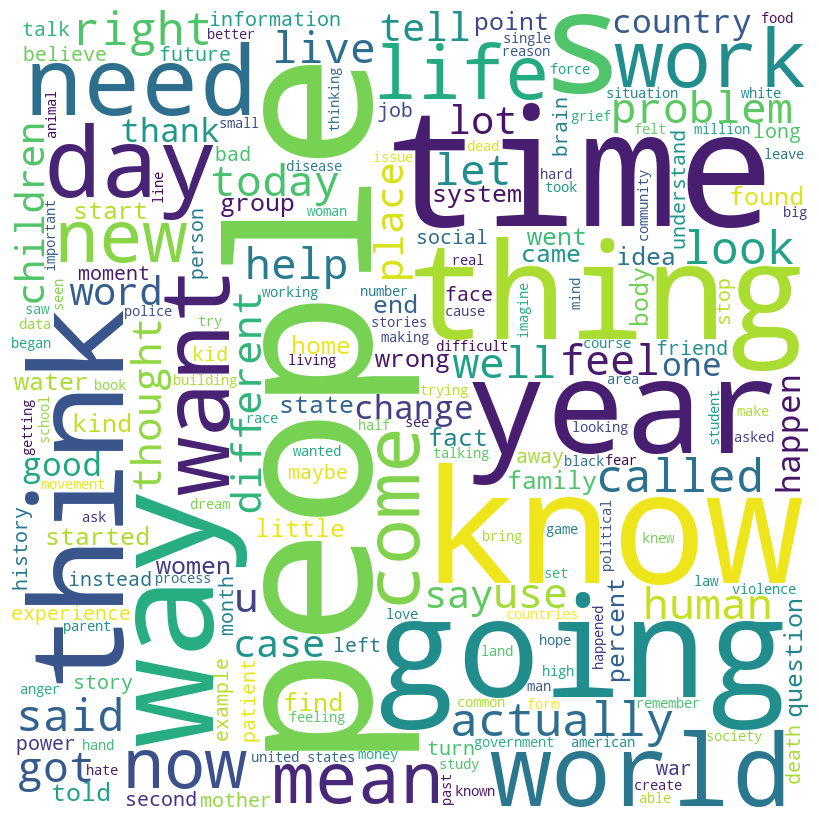

In [118]:
negative_words = ' '.join(df[df['sentiment'] < 0]['clean_transcript'])
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(negative_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [120]:
positive_words = ' '.join(df[df['sentiment'] > 0]['clean_transcript'])
positive_counts = pd.Series(positive_words.split()).value_counts()


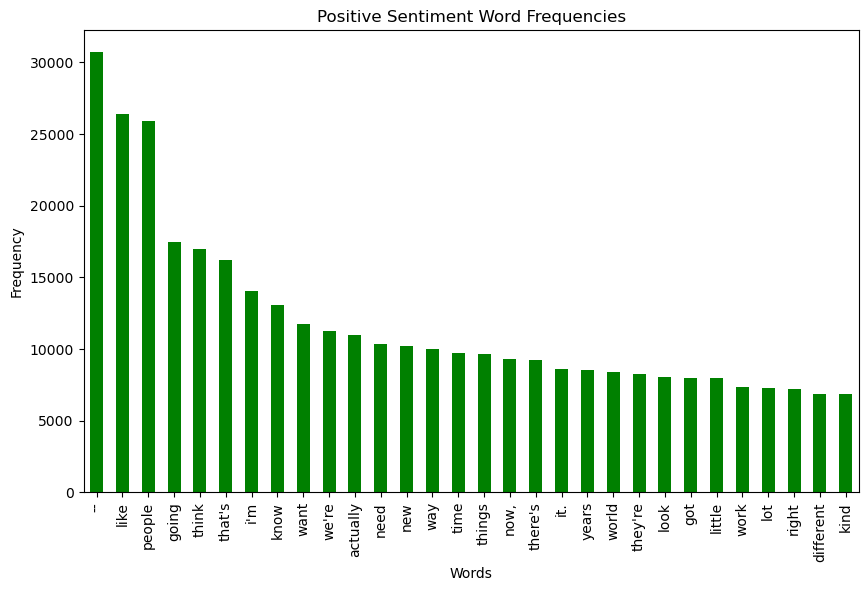

In [127]:
plt.figure(figsize=(10, 6))
positive_counts[:30].plot(kind='bar', color='green')
plt.title('Positive Sentiment Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [121]:
negative_words = ' '.join(df[df['sentiment'] < 0]['clean_transcript'])
negative_counts = pd.Series(negative_words.split()).value_counts()


In [123]:
negative_counts[:10]

people    1212
like       960
--         920
going      554
know       513
think      436
i'm        426
that's     423
time       407
want       405
Name: count, dtype: int64

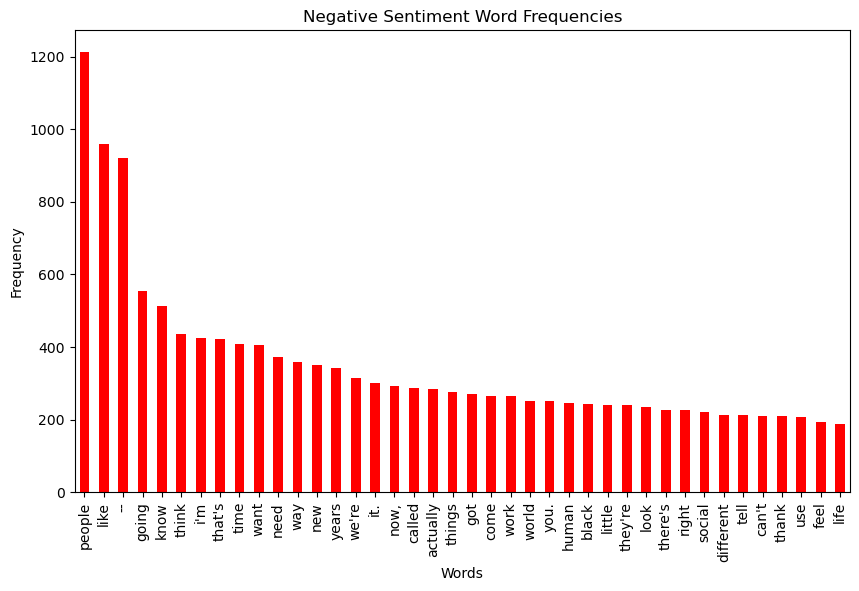

In [128]:
plt.figure(figsize=(10, 6))
negative_counts[:40].plot(kind='bar', color='red')
plt.title('Negative Sentiment Word Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()